In [40]:
from typing import List, TypedDict, Literal
from pydantic import BaseModel, Field

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

load_dotenv()

True

In [41]:
docs = (
    PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Company_Policies.pdf").load()
    + PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Company_Profile.pdf").load()
    + PyPDFLoader("C:\\Users\\PMYLS\\Desktop\\Gen-AI\\LangGraph\\self_RAG\\documents\\Product_and_Pricing.pdf").load()
)

In [42]:
chunks = RecursiveCharacterTextSplitter(
    chunk_size=600, chunk_overlap=150
).split_documents(docs)

In [43]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.from_documents(chunks, embeddings)
retriever = vector_store.as_retriever(search_kwargs={"k": 4})

In [44]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [45]:
# -----------------------------
# Graph State
# -----------------------------
class State(TypedDict):
    question: str

    # ✅ NEW: what we actually send to vector retriever
    retrieval_query: str
    rewrite_tries: int
    
    need_retrieval: bool
    docs: List[Document]
    relevant_docs: List[Document]
    context: str
    answer: str

    # Post-generation verification
    issup: Literal["fully_supported", "partially_supported", "no_support"]
    evidence: List[str]

    retries: int

    isuse: Literal["useful", "not_useful"]
    use_reason: str

In [46]:
class RetrieveDecision(BaseModel):
    should_retrieve: bool = Field(
        ...,
        description="True if external documents are needed to answer reliably, else False."
    )

decide_retrieval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You decide whether retrieval is needed.\n"
            "Return JSON that matches this schema:\n"
            "{{'should_retrieve': boolean}}\n\n"
            "Guidelines:\n"
            "- should_retrieve=True if answering requires specific facts, citations, or info likely not in the model.\n"
            "- should_retrieve=False for general explanations, definitions, or reasoning that doesn't need sources.\n"
            "- If unsure, choose True."
        ),
        ("human", "Question: {question}"),
    ]
)


# IMPORTANT: no `.content` for structured output
should_retrieve_llm = llm.with_structured_output(RetrieveDecision)

import json
import ast

def decide_retrieval(state: "State"):
    prompt = decide_retrieval_prompt.format_prompt(question=state["question"])
    response = llm.invoke(prompt)
    content = response.content.strip()
    print("LLM response:", content)  # Debug print

    try:
        return {"need_retrieval": json.loads(content)["should_retrieve"]}
    except Exception:
        try:
            return {"need_retrieval": ast.literal_eval(content)["should_retrieve"]}
        except Exception:
            # Handle 'should_retrieve: True' or similar
            if "True" in content:
                return {"need_retrieval": True}
            elif "False" in content:
                return {"need_retrieval": False}
            else:
                raise ValueError("Could not parse LLM output: " + content)

def route_after_decide(state: State) -> Literal["generate_direct", "retrieve"]:
    return "retrieve" if state["need_retrieval"] else "generate_direct"

In [47]:
# -----------------------------
# 2) Direct answer (no retrieval)
# -----------------------------
direct_generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer using only your general knowledge.\n"
            "If it requires specific company info, say:\n"
            "'I don't know based on my general knowledge.'"
        ),
        ("human", "{question}"),
    ]
)

def generate_direct(state: State):
    out = llm.invoke(direct_generation_prompt.format_messages(question=state["question"]))
    return {"answer": out.content}

In [48]:
# -----------------------------
# 3) Retrieve
# -----------------------------
def retrieve(state: State):
    q = state.get("retrieval_query") or state["question"]
    return {"docs": retriever.invoke(q)}

In [49]:
# -----------------------------
# 4) Relevance filter 
# -----------------------------
class RelevanceDecision(BaseModel):
    is_relevant: bool = Field(
        ...,
        description="True ONLY if the document contains info that can directly answer the question."
    )

is_relevant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are judging document relevance at a TOPIC level.\n"
            "Return JSON matching the schema.\n\n"
            "A document is relevant if it discusses the same entity or topic area as the question.\n"
            "It does NOT need to contain the exact answer.\n\n"
            "Examples:\n"
            "- HR policies are relevant to questions about notice period, probation, termination, benefits.\n"
            "- Pricing documents are relevant to questions about refunds, trials, billing terms.\n"
            "- Company profile is relevant to questions about leadership, culture, size, or strategy.\n\n"
            "Do NOT decide whether the document fully answers the question.\n"
            "That will be checked later by IsSUP.\n"
            "When unsure, return is_relevant=true."
        ),
        ("human", "Question:\n{question}\n\nDocument:\n{document}"),
    ]
)


relevance_llm = llm.with_structured_output(RelevanceDecision)

def is_relevant(state: State):
    relevant_docs: List[Document] = []
    for doc in state["docs"]:
        prompt = is_relevant_prompt.format_prompt(
            question=state["question"],
            document=doc.page_content
        )
        response = llm.invoke(prompt)
        content = response.content.strip()
        print("LLM response:", content)  # Debug print

        try:
            decision = json.loads(content)
        except Exception:
            # Try to fix common issues
            content_fixed = content.replace("'", "\"")
            if content_fixed.startswith("{") and content_fixed.endswith("}"):
                try:
                    decision = json.loads(content_fixed)
                except Exception:
                    decision = None
            else:
                # Handle 'is_relevant: True' or similar
                if "True" in content or "False" in content:
                    val = "True" in content
                    decision = {"is_relevant": val}
                else:
                    decision = None

        if decision and decision.get("is_relevant"):
            relevant_docs.append(doc)
    return {"relevant_docs": relevant_docs}

def route_after_relevance(state: State) -> Literal["generate_from_context", "no_answer_found"]:
    if state.get("relevant_docs") and len(state["relevant_docs"]) > 0:
        return "generate_from_context"
    return "no_answer_found"

In [50]:
# -----------------------------
# 5) Generate from context
# -----------------------------
rag_generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a business rag chatbot.\n\n"
            "You will receive a CONTEXT block from internal company documents.\n"
            "Task:\n"
            "Answer the question based on the context"
            "Dont mention that you are getting a context in your answer"
        ),
        ("human", "Question:\n{question}\n\nContext:\n{context}"),
    ]
)

def generate_from_context(state: State):
    context = "\n\n---\n\n".join([d.page_content for d in state.get("relevant_docs", [])]).strip()
    if not context:
        return {"answer": "No answer found.", "context": ""}
    out = llm.invoke(
        rag_generation_prompt.format_messages(question=state["question"], context=context)
    )
    return {"answer": out.content, "context": context}

def no_answer_found(state: State):
    return {"answer": "No answer found.", "context": ""}

In [51]:
# -----------------------------
# 6) IsSUP verify + revise loop
# -----------------------------
class IsSUPDecision(BaseModel):
    issup: Literal["fully_supported", "partially_supported", "no_support"]
    evidence: List[str] = Field(default_factory=list)

issup_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are verifying whether the ANSWER is supported by the CONTEXT.\n"
            "Return JSON with keys: issup, evidence.\n"
            "issup must be one of: fully_supported, partially_supported, no_support.\n\n"
            "How to decide issup:\n"
            "- fully_supported:\n"
            "  Every meaningful claim is explicitly supported by CONTEXT, and the ANSWER does NOT introduce\n"
            "  any qualitative/interpretive words that are not present in CONTEXT.\n"
            "  (Examples of disallowed words unless present in CONTEXT: culture, generous, robust, designed to,\n"
            "  supports professional development, best-in-class, employee-first, etc.)\n\n"
            "- partially_supported:\n"
            "  The core facts are supported, BUT the ANSWER includes ANY abstraction, interpretation, or qualitative\n"
            "  phrasing not explicitly stated in CONTEXT (e.g., calling policies 'culture', saying leave is 'generous',\n"
            "  or inferring outcomes like 'supports professional development').\n\n"
            "- no_support:\n"
            "  The key claims are not supported by CONTEXT.\n\n"
            "Rules:\n"
            "- Be strict: if you see ANY unsupported qualitative/interpretive phrasing, choose partially_supported.\n"
            "- If the answer is mostly unrelated to the question or unsupported, choose no_support.\n"
            "- Evidence: include up to 3 short direct quotes from CONTEXT that support the supported parts.\n"
            "- Do not use outside knowledge."
        ),
        (
            "human",
            "Question:\n{question}\n\n"
            "Answer:\n{answer}\n\n"
            "Context:\n{context}\n"
        ),
    ]
)



issup_llm = llm.with_structured_output(IsSUPDecision)

import json
import ast

def is_sup(state: State):
    prompt = issup_prompt.format_prompt(
        question=state["question"],
        answer=state.get("answer", ""),
        context=state.get("context", ""),
    )
    response = llm.invoke(prompt)
    content = response.content.strip()
    print("LLM response:", content)  # Debug print

    try:
        decision = json.loads(content)
    except Exception:
        try:
            decision = ast.literal_eval(content)
        except Exception:
            decision = None

    if decision:
        return {"issup": decision.get("issup", ""), "evidence": decision.get("evidence", [])}
    else:
        return {"issup": "", "evidence": []}

MAX_RETRIES = 10

def route_after_issup(state: State) -> Literal["accept_answer", "revise_answer"]:
    # accept if fully supported
    if state.get("issup") == "fully_supported":
        return "accept_answer"

    # stop if we've already tried enough
    if state.get("retries", 0) >= MAX_RETRIES:
        return "accept_answer"   # or return a "give_up" node if you want

    # otherwise revise again
    return "revise_answer"

In [52]:
def accept_answer(state: State):
    return {}  # keep answer as-is

In [53]:
revise_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a STRICT reviser.\n\n"
            "You must output based on the following format:\n\n"
            "FORMAT (quote-only answer):\n"
            "- <direct quote from the CONTEXT>\n"
            "- <direct quote from the CONTEXT>\n\n"
            "Rules:\n"
            "- Use ONLY the CONTEXT.\n"
            "- Do NOT add any new words besides bullet dashes and the quotes themselves.\n"
            "- Do NOT explain anything.\n"
            "- Do NOT say 'context', 'not mentioned', 'does not mention', 'not provided', etc.\n"
        ),
        (
            "human",
            "Question:\n{question}\n\n"
            "Current Answer:\n{answer}\n\n"
            "CONTEXT:\n{context}"
        ),
    ]
)



def revise_answer(state: State):
    out = llm.invoke(
        revise_prompt.format_messages(
            question=state["question"],
            answer=state.get("answer", ""),
            context=state.get("context", ""),
        )
    )
    return {
        "answer": out.content,
        "retries": state.get("retries", 0) + 1,  # ✅ increment
    }

In [54]:
class IsUSEDecision(BaseModel):
    isuse: Literal["useful", "not_useful"]
    reason: str = Field(..., description="Short reason in 1 line.")

isuse_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are judging USEFULNESS of the ANSWER for the QUESTION.\n\n"
            "Goal:\n"
            "- Decide if the answer actually addresses what the user asked.\n\n"
            "Return JSON with keys: isuse, reason.\n"
            "isuse must be one of: useful, not_useful.\n\n"
            "Rules:\n"
            "- useful: The answer directly answers the question or provides the requested specific info.\n"
            "- not_useful: The answer is generic, off-topic, or only gives related background without answering.\n"
            "- Do NOT use outside knowledge.\n"
            "- Do NOT re-check grounding (IsSUP already did that). Only check: 'Did we answer the question?'\n"
            "- Keep reason to 1 short line."
        ),
        ("human",
            "Question:\n{question}\n\nAnswer:\n{answer}"
        ),
    ]
)

isuse_llm = llm.with_structured_output(IsUSEDecision)

import json
import ast

def is_use(state: State):
    prompt = isuse_prompt.format_prompt(
        question=state["question"],
        answer=state.get("answer", ""),
    )
    response = llm.invoke(prompt)
    content = response.content.strip()
    print("LLM response:", content)  # Debug print

    try:
        decision = json.loads(content)
    except Exception:
        try:
            decision = ast.literal_eval(content)
        except Exception:
            decision = None

    if decision:
        return {"isuse": decision.get("isuse", ""), "use_reason": decision.get("reason", "")}
    else:
        return {"isuse": "", "use_reason": ""}


def route_after_isuse(state: State) -> Literal["END", "no_answer_found"]:
    if state.get("isuse") == "useful":
        return "END"
    return "no_answer_found"

In [55]:
class RewriteDecision(BaseModel):
    retrieval_query: str = Field(
        ...,
        description="Rewritten query optimized for vector retrieval against internal company PDFs."
    )

rewrite_for_retrieval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Rewrite the user's QUESTION into a query optimized for vector retrieval over INTERNAL company PDFs.\n\n"
            "Rules:\n"
            "- Keep it short (6–16 words).\n"
            "- Preserve key entities (e.g., NexaAI, plan names).\n"
            "- Add 2–5 high-signal keywords that likely appear in policy/pricing docs.\n"
            "- Remove filler words.\n"
            "- Do NOT answer the question.\n"
            "- Output JSON with key: retrieval_query\n\n"
            "Examples:\n"
            "Q: 'Do NexaAI plans include a free trial?'\n"
            "-> {{'retrieval_query': 'NexaAI free trial duration trial period plans'}}\n\n"
            "Q: 'What is NexaAI refund policy?'\n"
            "-> {{'retrieval_query': 'NexaAI refund policy cancellation refund timeline charges'}}"
        ),
        (
            "human",
            "QUESTION:\n{question}\n\n"
            "Previous retrieval query:\n{retrieval_query}\n\n"
            "Answer (if any):\n{answer}"
        ),
    ]
)



rewrite_llm = llm.with_structured_output(RewriteDecision)

def rewrite_question(state: State):
    decision: RewriteDecision = rewrite_llm.invoke(
        rewrite_for_retrieval_prompt.format_messages(
            question=state["question"],
            retrieval_query=state.get("retrieval_query", ""),
            answer=state.get("answer", ""),
        )
    )

    return {
        "retrieval_query": decision.retrieval_query,
        "rewrite_tries": state.get("rewrite_tries", 0) + 1,
        # ✅ optional: reset these so next pass is clean
        "docs": [],
        "relevant_docs": [],
        "context": "",
    }

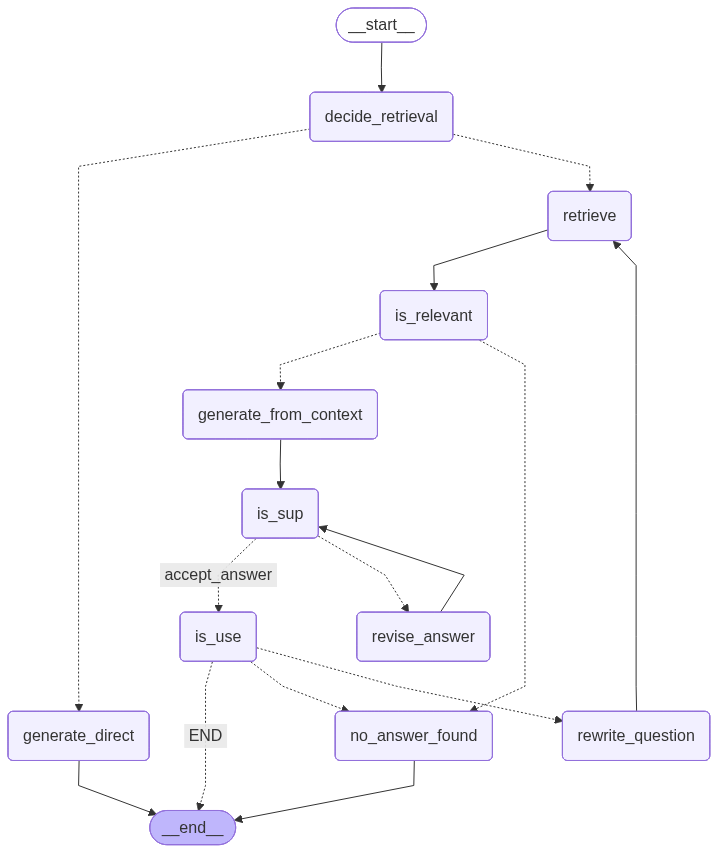

In [56]:
# -----------------------------
# Build graph (UPDATED: IsUSE -> if not useful -> rewrite -> retrieve; else END)
# -----------------------------
g = StateGraph(State)

# --------------------
# Nodes
# --------------------
g.add_node("decide_retrieval", decide_retrieval)
g.add_node("generate_direct", generate_direct)
g.add_node("retrieve", retrieve)

g.add_node("is_relevant", is_relevant)
g.add_node("generate_from_context", generate_from_context)
g.add_node("no_answer_found", no_answer_found)

# IsSUP + revise loop
g.add_node("is_sup", is_sup)
g.add_node("revise_answer", revise_answer)

# IsUSE
g.add_node("is_use", is_use)

# ✅ NEW: rewrite question for better retrieval
g.add_node("rewrite_question", rewrite_question)

# --------------------
# Edges
# --------------------
g.add_edge(START, "decide_retrieval")

g.add_conditional_edges(
    "decide_retrieval",
    route_after_decide,
    {"generate_direct": "generate_direct", "retrieve": "retrieve"},
)

g.add_edge("generate_direct", END)

# Retrieve -> relevance -> (generate | no_answer_found)
g.add_edge("retrieve", "is_relevant")

g.add_conditional_edges(
    "is_relevant",
    route_after_relevance,
    {
        "generate_from_context": "generate_from_context",
        "no_answer_found": "no_answer_found",
    },
)

g.add_edge("no_answer_found", END)

# --------------------
# Generate -> IsSUP -> (IsUSE | revise) loop
# --------------------
g.add_edge("generate_from_context", "is_sup")

g.add_conditional_edges(
    "is_sup",
    route_after_issup,
    {
        "accept_answer": "is_use",      # fully_supported (or max retries) -> go to IsUSE
        "revise_answer": "revise_answer",
    },
)

g.add_edge("revise_answer", "is_sup")  # 🔁 loop back to IsSUP

# --------------------
# IsUSE routing
#   - useful -> END
#   - not_useful -> rewrite_question -> retrieve (try again)
#   - give up -> no_answer_found -> END
# --------------------
g.add_conditional_edges(
    "is_use",
    route_after_isuse,
    {
        "END": END,
        "rewrite_question": "rewrite_question",
        "no_answer_found": "no_answer_found",
    },
)

# rewrite -> retrieve -> relevance -> ...
g.add_edge("rewrite_question", "retrieve")

app = g.compile()
app

In [57]:
# -----------------------------
# Run the graph
# -----------------------------
initial_state = {
    "question": "Describe NexaAI’s company culture.",
    "retrieval_query": "What is the refund policy of NexaAI",  # ✅ important
    "rewrite_tries": 0,                                        # ✅ important
    "docs": [],
    "relevant_docs": [],
    "context": "",
    "answer": "",
    "issup": "",
    "evidence": [],
    "retries": 0,
    "isuse": "not_useful",
    "use_reason": "",
}


result = app.invoke(
    initial_state,
    config={"recursion_limit": 80},  # allow revise → verify loops
)

# -----------------------------
# Debug / inspection output (clean + complete)
# -----------------------------
print("\n===== RAG EXECUTION RESULT =====\n")

print("Question:", initial_state.get("question"))
print("Need Retrieval:", result.get("need_retrieval"))

# If you added these counters/fields in your State:
print("Rewrite tries (retrieval):", result.get("rewrite_tries", 0))
print("Support revise tries:", result.get("retries", 0))

print("\nRetrieval:")
print("  Total retrieved docs:", len(result.get("docs", []) or []))
print("  Relevant docs:", len(result.get("relevant_docs", []) or []))

# Optional: show sources/pages for relevant docs
relevant_docs = result.get("relevant_docs", []) or []
if relevant_docs:
    print("\nRelevant docs (source/page):")
    for i, d in enumerate(relevant_docs, 1):
        src = (d.metadata or {}).get("source", "unknown")
        page = (d.metadata or {}).get("page", None)
        title = (d.metadata or {}).get("title", "")
        extra = f", title={title}" if title else ""
        if page is not None:
            print(f"  {i}. source={src}, page={page}{extra}")
        else:
            print(f"  {i}. source={src}{extra}")

print("\nVerification (IsSUP):")
print("  issup:", result.get("issup"))
evidence = result.get("evidence", []) or []
if evidence:
    print("  evidence:")
    for e in evidence:
        print("   -", e)
else:
    print("  evidence: (none)")

print("\nUsefulness (IsUSE):")
print("  isuse:", result.get("isuse"))
print("  reason:", result.get("use_reason", ""))

print("\nFinal Answer:")
print(result.get("answer"))

print("\n===============================\n")

LLM response: {'should_retrieve': True}
LLM response: {
  "is_relevant": true
}
LLM response: {
  "is_relevant": false
}
LLM response: {
  "is_relevant": true
}
LLM response: ```json
{
  "is_relevant": false
}
```
LLM response: {
  "issup": "partially_supported",
  "evidence": [
    "NexaAI is committed to maintaining a fair, inclusive, and performance-driven workplace.",
    "All employment decisions are made without discrimination.",
    "Employees are encouraged to maintain a healthy work-life balance."
  ]
}
LLM response: {
  "issup": "fully_supported",
  "evidence": [
    "NexaAI is committed to maintaining a fair, inclusive, and performance-driven workplace.",
    "Employees are encouraged to maintain a healthy work-life balance."
  ]
}
LLM response: {
  "isuse": "useful",
  "reason": "The answer provides specific details about NexaAI's company culture."
}

===== RAG EXECUTION RESULT =====

Question: Describe NexaAI’s company culture.
Need Retrieval: True
Rewrite tries (retrieval